<a href="https://colab.research.google.com/github/imn167/VAE_SS/blob/main/GoM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from function.VAE_GoM import *

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output #
import time
import openturns as ot
from sklearn.decomposition import PCA

On teste le VAE sur une distribution gaussienne tronquée tel que les coordonnées des vecteurs soient supérieurs à un seuil.  

Pour des soucis d'efficacité et de faisabilité on choisit de tronquer seulement sur 2 coordonnées.

In [3]:
one_mode = np.load("3_component_1Side_truncated (1).npy")
d = one_mode.shape[1]

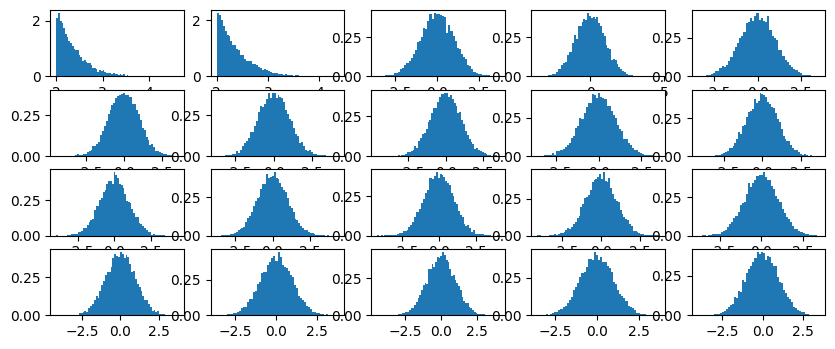

In [4]:
plt.figure(figsize=(10,5))
for i in range(d):
  plt.subplot(5,5, i+1)
  plt.hist(one_mode[:,i], density=True, bins = 'auto');

In [ ]:
encoder = Encoder(d,2, True)
decoder = Decoder(d,2, True)
mixture = MoGPrior(2,6)
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001))
history = vae.fit(one_mode,epochs=110,
    batch_size=100,
    shuffle=True)

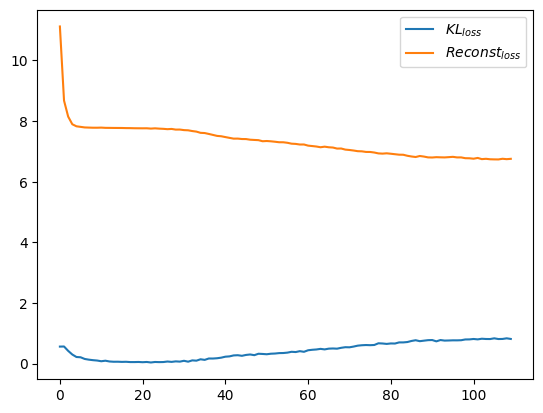

In [59]:
plt.plot(history.history['kl_loss'],  label = r'$KL_{loss}$')
plt.plot(history.history['reconstruction_loss'],   label = r'$Reconst_{loss}$')
#plt.plot(history.history['loss'], label = r'$Total_{loss}$')
plt.legend()

In [60]:
mixture.means

<tf.Variable 'means:0' shape=(6, 2) dtype=float32, numpy=
array([[-0.57014847,  1.4306192 ],
       [-1.1379402 ,  2.1389263 ],
       [-0.8371155 ,  0.673414  ],
       [ 0.0633812 ,  0.95271724],
       [-0.41070387,  0.90930885],
       [-0.19634096,  1.4038209 ]], dtype=float32)>

In [61]:
tf.exp(mixture.logvars*0.5)

<tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[0.6682398 , 0.86026156],
       [0.74046123, 1.0582775 ],
       [0.76382923, 0.545659  ],
       [0.70262104, 0.7509436 ],
       [1.0118479 , 0.72015464],
       [0.6980259 , 0.8637087 ]], dtype=float32)>

In [62]:
weights = tf.nn.softmax(mixture.w)
weights

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.1634358 , 0.57043624, 0.04478895, 0.02814733, 0.0479902 ,
        0.1452015 ]], dtype=float32)>

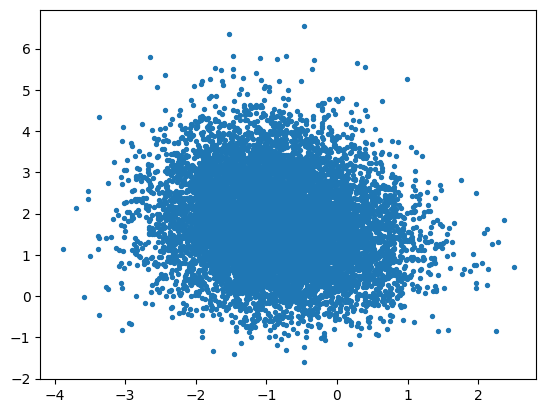

In [63]:
ColDist = [ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(mixture.means, mixture.logvars)]
weight = np.array(tf.nn.softmax(mixture.w, axis =1)).reshape(-1)
myMixture = ot.Mixture(ColDist, weight)
samples =myMixture.getSample(10000)
plt.scatter(samples[:,0], samples[:,1], s=8)

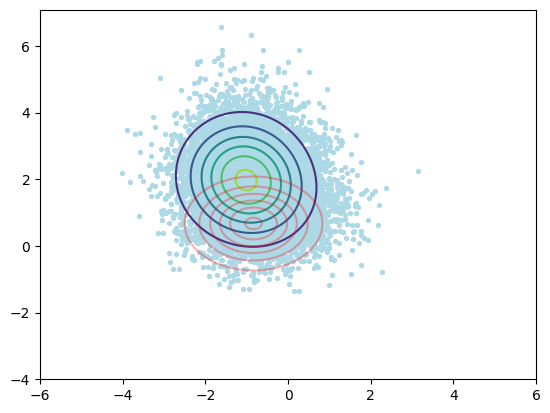

In [65]:
X, Y = np.meshgrid(np.linspace(-6,6, 1000), np.linspace(-4,6, 1000))
pos = np.dstack((X,Y))
from scipy.stats import multivariate_normal
rv1  = multivariate_normal(mixture.means[0], np.diag(tf.exp(mixture.logvars[0]*0.5))) 
rv2  = multivariate_normal(mixture.means[1], np.diag(tf.exp(mixture.logvars[1]*0.5)))
rv3  = multivariate_normal(mixture.means[2], np.diag(tf.exp(mixture.logvars[2]*0.5)))

Z    = rv1.pdf(pos) * weights[0,0] + rv2.pdf(pos) * weights[0,1] #+ rv3.pdf(pos) * weights[0,2]

plt.contour(X, Y, Z)
#plt.contour(X,Y, rv2.pdf(pos), colors = 'red', alpha = .3)
#plt.contour(X,Y, rv1.pdf(pos), colors = 'red', alpha = .3)
plt.contour(X,Y, rv3.pdf(pos), colors = 'red', alpha = .3)

_,_, z = encoder(one_mode)
plt.scatter(z[:, 0],z[:,1], s=8, c = 'lightblue');

In [ ]:
_,_, z = encoder(one_mode)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

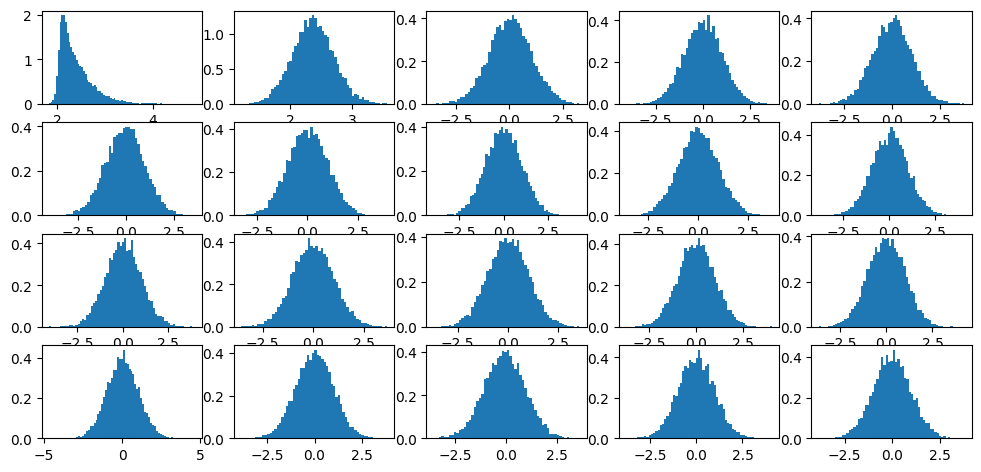

In [ ]:
plt.figure(figsize = (12,7))
for i in range(d):
  plt.subplot(5,5,i+1)
  plt.hist(sample[:,i], bins = 'auto', density=True);

Difficulté à reperer la 2e composantes 

In [ ]:
encoder = Encoder(d,2, True)
decoder = Decoder(d,2, True)
ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3))
ae.fit(one_mode,epochs=200, batch_size=32, shuffle=True)

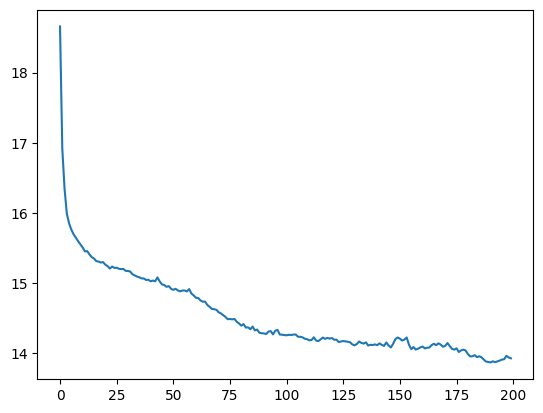

In [110]:
plt.plot(ae.history.history['loss'])

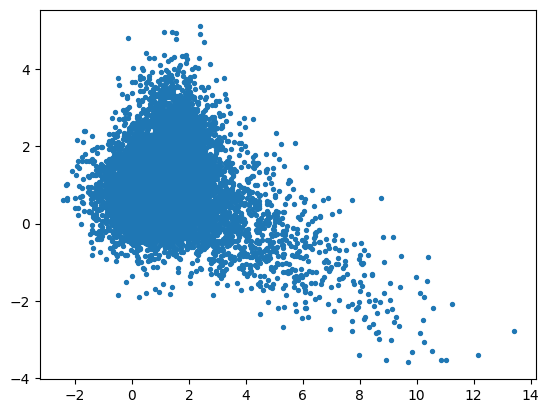

In [111]:
z_mean, _, _ = encoder(one_mode)
plt.scatter(z[:,0], z[:,1], s= 8)

In [113]:
pca = PCA(n_components=10)
linear_latent = pca.fit_transform(one_mode)
linear_latent

array([[ 0.60735077,  0.99165289, -1.02328236, ..., -1.13788481,
        -0.13978515, -1.75545827],
       [ 0.74740937,  0.20351513, -0.81957766, ...,  0.32188663,
         0.28182003,  1.93676361],
       [ 0.53640675, -1.47969867, -2.2695578 , ..., -0.05572947,
        -0.32644121,  0.84256073],
       ...,
       [ 3.08031369, -1.48087304, -0.05574791, ...,  0.27726808,
        -0.38934078,  0.99394463],
       [ 2.13747682,  0.82287676, -0.72893248, ...,  1.9801579 ,
        -1.2342473 , -1.39566921],
       [-0.61834263, -0.48763683,  0.41403283, ..., -2.63548411,
         1.6169253 ,  0.70166329]])

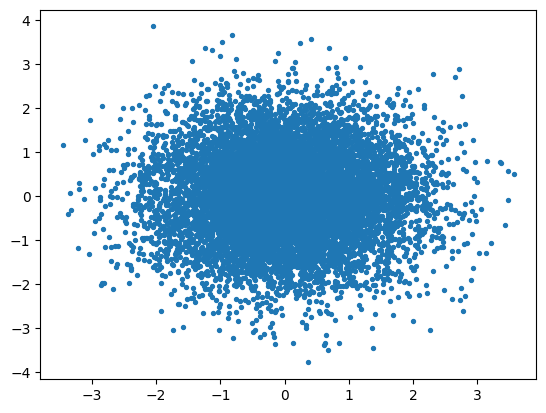

In [114]:
plt.scatter(linear_latent[:,8], linear_latent[:,9], s=8)

In [ ]:
#_,_,z = encoder(one_mode)
mixture = MoGPrior(2,6)
mixture.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=.5, beta_2=.9))
mixture.fit(z, epochs=220, batch_size=64)

In [145]:
mixture.means

<tf.Variable 'means:0' shape=(6, 2) dtype=float32, numpy=
array([[-0.90124655, -0.9426342 ],
       [-0.0360557 , -2.0584195 ],
       [-1.0122788 , -0.88730544],
       [-0.20209251, -1.5930816 ],
       [-0.51167357, -2.443565  ],
       [ 0.21011426, -0.7513064 ]], dtype=float32)>

In [146]:
tf.exp(0.5*mixture.logvars)

<tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[1.0490644 , 0.7960004 ],
       [1.3322841 , 0.94240266],
       [1.062607  , 1.2559574 ],
       [0.71866024, 1.0049994 ],
       [1.5999919 , 1.1316406 ],
       [0.88155025, 0.8405344 ]], dtype=float32)>

In [147]:
weights = tf.nn.softmax(mixture.w)
weights

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.1249818 , 0.26178175, 0.1996905 , 0.23815686, 0.06449342,
        0.11089559]], dtype=float32)>

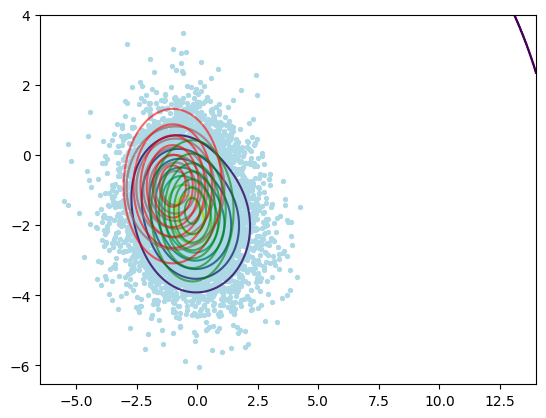

In [149]:
X, Y = np.meshgrid(np.linspace(-4,12, 1000), np.linspace(-4,4, 1000))
pos = np.dstack((X,Y))
from scipy.stats import multivariate_normal
rv1  = multivariate_normal(mixture.means[0], np.diag(tf.exp(mixture.logvars[0]*0.5))) 
rv2  = multivariate_normal(mixture.means[1], np.diag(tf.exp(mixture.logvars[1]*0.5)))
rv3  = multivariate_normal(mixture.means[2], np.diag(tf.exp(mixture.logvars[2]*0.5)))
rv4  = multivariate_normal(mixture.means[3], np.diag(tf.exp(mixture.logvars[3]*0.5)))
Z    = rv1.pdf(pos) * weights[0,0] + rv2.pdf(pos) * weights[0,1] #+ rv3.pdf(pos) * weights[0,2]

plt.contour(X, Y, Z)
plt.contour(X,Y, rv1.pdf(pos), colors = 'red', alpha = .3)
plt.contour(X,Y, rv1.pdf(pos), colors = 'gray', alpha = .6)
plt.contour(X,Y, rv3.pdf(pos), colors = 'red', alpha = .6)
plt.contour(X,Y, rv4.pdf(pos), colors = 'green', alpha = .6)
_,_, z = encoder(one_mode)
plt.scatter(z[:, 0], z[:,1], s=8, c = 'lightblue');

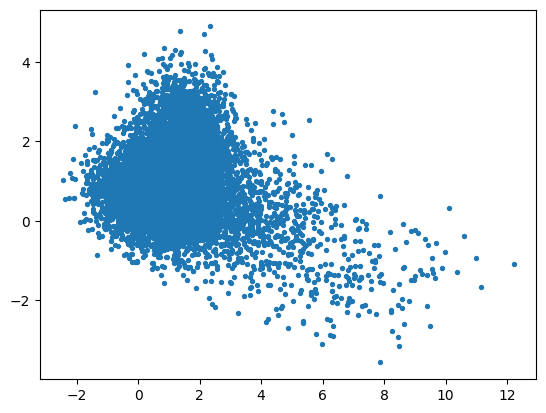

In [97]:
ColDist = [ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(mixture.means, mixture.logvars)]
weight = np.array(tf.nn.softmax(mixture.w, axis =1)).reshape(-1)
myMixture = ot.Mixture(ColDist, weight)
samples =myMixture.getSample(10000)
plt.scatter(samples[:,0], samples[:,1], s=8)


In [ ]:

vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001))
history = vae.fit(one_mode,epochs=100,
    batch_size=128,
    shuffle=True) ##### Don't work, hard to get out from the collapse problem 

In [3]:
two_mode = np.load('2_component_truncated.npy')
d = two_mode.shape[1]
d

20

CPU times: total: 891 ms
Wall time: 1.23 s


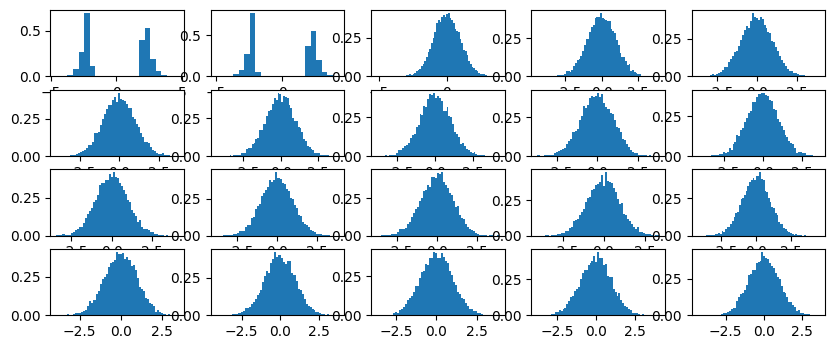

In [25]:
%%time
plt.figure(figsize=(10,5))
for i in range(d):
  plt.subplot(5,5, i+1)
  plt.hist(two_mode[:,i], density=True, bins = 'auto');

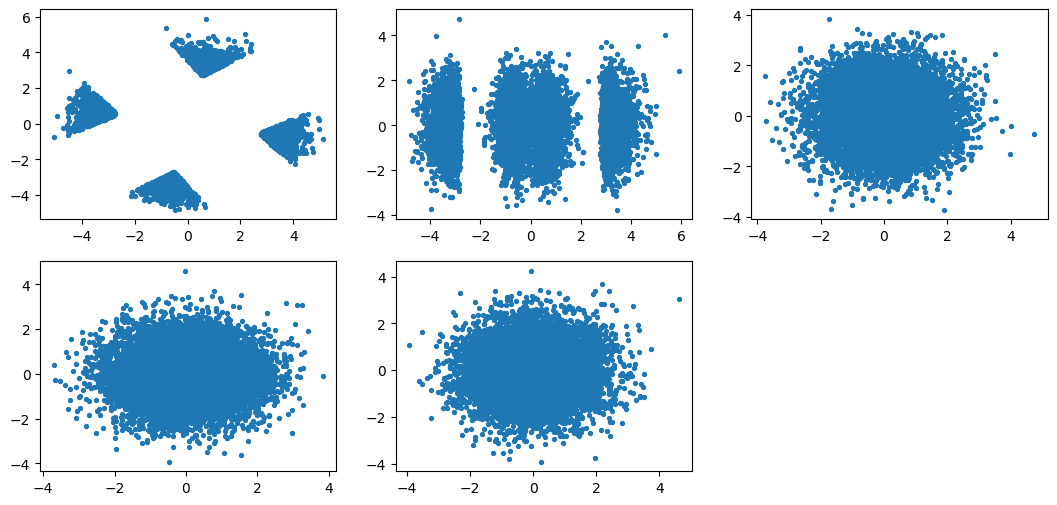

In [8]:
pca = PCA(n_components=10)
two_mode_pca = pca.fit_transform(two_mode)
plt.figure(figsize=(13,6))
for i in range(5):
    plt.subplot(2,3, i+1)
    plt.scatter(two_mode_pca[:, i], two_mode_pca[:,i+1], s=8)

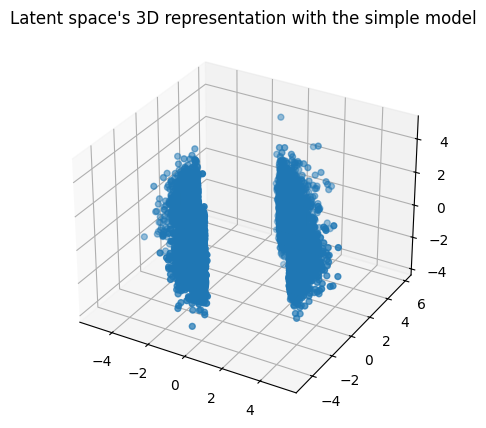

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize= (9,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(two_mode_pca[:, 0], two_mode_pca[:, 1], two_mode_pca[:, 2], s= 18);
ax.set_title("Latent space's 3D representation with the simple model");

In [5]:
encoder = Encoder(d,2, True)
decoder = Decoder(d,2, True)
ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3))
ae.fit(two_mode,epochs=110, batch_size=150, shuffle=True)


Epoch 1/110
67/67 [==============================] - 2s 2ms/step - loss: 28.4605
Epoch 2/110
67/67 [==============================] - 0s 1ms/step - loss: 23.3990
Epoch 3/110
67/67 [==============================] - 0s 2ms/step - loss: 18.6553
Epoch 4/110
67/67 [==============================] - 0s 2ms/step - loss: 18.1803
Epoch 5/110
67/67 [==============================] - 0s 3ms/step - loss: 18.0667
Epoch 6/110
67/67 [==============================] - 0s 2ms/step - loss: 17.9792
Epoch 7/110
67/67 [==============================] - 0s 2ms/step - loss: 17.8923
Epoch 8/110
67/67 [==============================] - 0s 2ms/step - loss: 17.7787
Epoch 9/110
67/67 [==============================] - 0s 2ms/step - loss: 17.6209
Epoch 10/110
67/67 [==============================] - 0s 2ms/step - loss: 17.4812
Epoch 11/110
67/67 [==============================] - 0s 2ms/step - loss: 17.3572
Epoch 12/110
67/67 [==============================] - 0s 2ms/step - loss: 17.2374
Epoch 13/110
67/67 [====

In [6]:
z_mean, _, _ = encoder(two_mode)
z_mean

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[2.9580154 , 3.080845  ],
       [1.7177722 , 1.9545115 ],
       [0.04024974, 5.5511403 ],
       ...,
       [1.8731772 , 2.3642762 ],
       [0.8541575 , 7.7899585 ],
       [2.486569  , 2.4647691 ]], dtype=float32)>

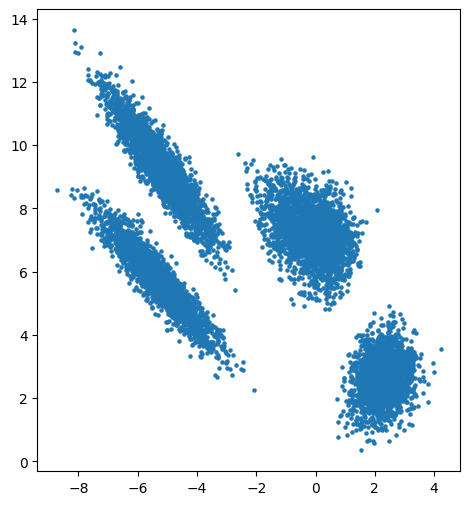

In [7]:
z_mean, _,_ = encoder(two_mode)
plt.figure(figsize=(12,6))
for i in range(1):
    plt.subplot(1,2, i+1)
    plt.scatter(z_mean[:, i], z_mean[:,i+1], s = 5)

In [26]:
%%time
mixture = MoGPrior(2,4)
mixture.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
mixture.fit(z_mean, epochs=100, batch_size=64)

Epoch 1/100
157/157 [==============================] - 1s 1ms/step - loss: 24.2890
Epoch 2/100
157/157 [==============================] - 0s 1ms/step - loss: 20.5951
Epoch 3/100
157/157 [==============================] - 0s 1ms/step - loss: 17.7781
Epoch 4/100
157/157 [==============================] - 0s 1ms/step - loss: 15.5811
Epoch 5/100
157/157 [==============================] - 0s 1ms/step - loss: 13.8645
Epoch 6/100
157/157 [==============================] - 0s 1ms/step - loss: 12.4444
Epoch 7/100
157/157 [==============================] - 0s 1ms/step - loss: 11.2976
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 10.3714
Epoch 9/100
157/157 [==============================] - 0s 1ms/step - loss: 9.5990
Epoch 10/100
157/157 [==============================] - 0s 1ms/step - loss: 8.1240
Epoch 11/100
157/157 [==============================] - 0s 1ms/step - loss: 6.9183
Epoch 12/100
157/157 [==============================] - 0s 1ms/step - loss: 6.3397
Epoch

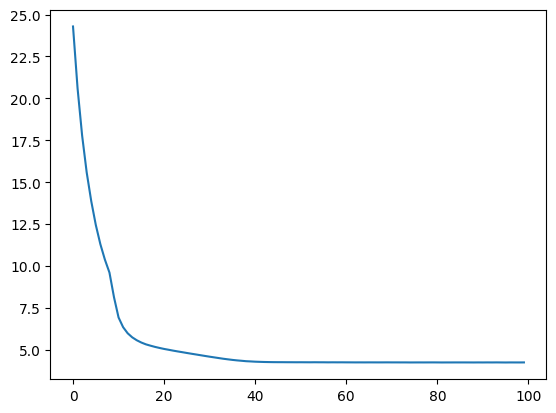

In [27]:
plt.plot(mixture.history.history['loss'])

In [28]:
mixture.means

<tf.Variable 'means:0' shape=(4, 2) dtype=float32, numpy=
array([[ 2.3236547,  2.7519648],
       [-3.5860555,  7.446608 ],
       [ 1.6523228,  1.7367188],
       [-0.7067452,  1.5975465]], dtype=float32)>

In [18]:
tf.exp(0.5*mixture.logvars)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[1.7492355 , 0.63128304],
       [1.4811053 , 1.2058413 ],
       [0.8589046 , 1.2039146 ],
       [6.573908  , 2.7897606 ]], dtype=float32)>

In [34]:
weights = tf.nn.softmax(mixture.w)
weights.shape[1]

4

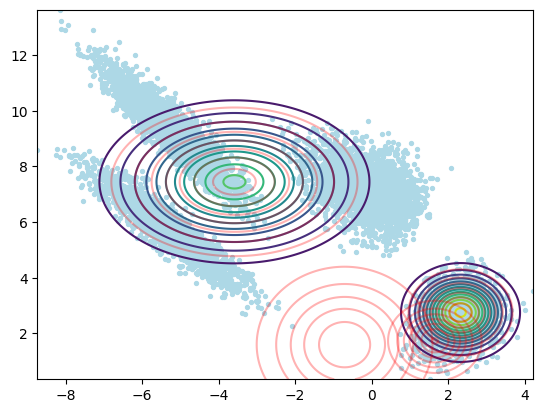

In [38]:
X, Y = np.meshgrid(np.linspace(min(z_mean.numpy()[:,0]),max(z_mean.numpy()[:,0]), 1000), np.linspace(min(z_mean.numpy()[:,1]),max(z_mean.numpy()[:,1]), 1000))
pos = np.dstack((X,Y))
rv =  [sp.multivariate_normal(mu, np.diag(tf.exp(sigma*0.5))) for mu, sigma in zip(mixture.means, mixture.logvars)]

Z    = rv1.pdf(pos) * weights[0,0] + rv2.pdf(pos) * weights[0,1] #+ rv3.pdf(pos) * weights[0,2]

plt.contour(X, Y, Z, levels = 15)
for i in range(weights.shape[1]):
    plt.contour(X,Y, rv[i].pdf(pos), colors = 'red', alpha = .3)
#plt.contour(X,Y, rv1.pdf(pos), colors = 'red', alpha = .3)
#plt.contour(X,Y, rv1.pdf(pos), colors = 'black', alpha = .6)
#plt.contour(X,Y, rv3.pdf(pos), colors = 'pink', alpha = .6)
#plt.contour(X,Y, rv4.pdf(pos), colors = 'green', alpha = .6)
z,_, _ = encoder(two_mode)
plt.scatter(z[:, 0], z[:,1], s=8, c = 'lightblue');

In [20]:
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
vae.fit(two_mode, epochs = 150, batch_size = 100, shuffle = True) 

Epoch 1/150
100/100 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - kl_loss: 2.7136 - reconstruction_loss: 9.4042
Epoch 2/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 2.1433 - reconstruction_loss: 7.9107
Epoch 3/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 2.0573 - reconstruction_loss: 7.8109
Epoch 4/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.9727 - reconstruction_loss: 7.8140
Epoch 5/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.9689 - reconstruction_loss: 7.7736
Epoch 6/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.9175 - reconstruction_loss: 7.7854
Epoch 7/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.8786 - reconstruction_loss: 7.7750
Epoch 8/150
100/100 [==============================] - 0s 2ms/

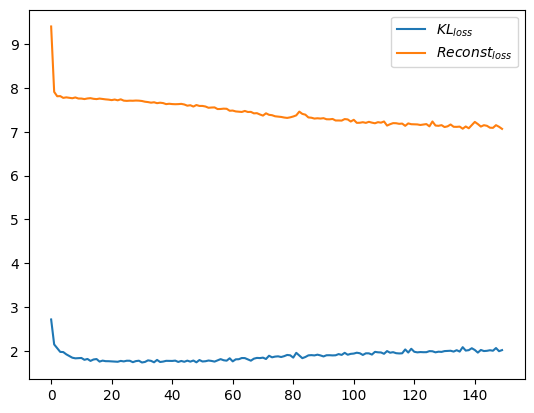

In [21]:
plt.plot(vae.history.history['kl_loss'], label = r'$KL_{loss}$')
plt.plot(vae.history.history['reconstruction_loss'], label = r'$Reconst_{loss}$')
plt.legend();

In [22]:
z_mean,_, _ = encoder(two_mode)

ColDist = [ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(mixture.means, mixture.logvars)]
weight = np.array(tf.nn.softmax(mixture.w, axis =1)).reshape(-1)
myMixture = ot.Mixture(ColDist, weight)
z =myMixture.getSample(10000)
z= np.array(z)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

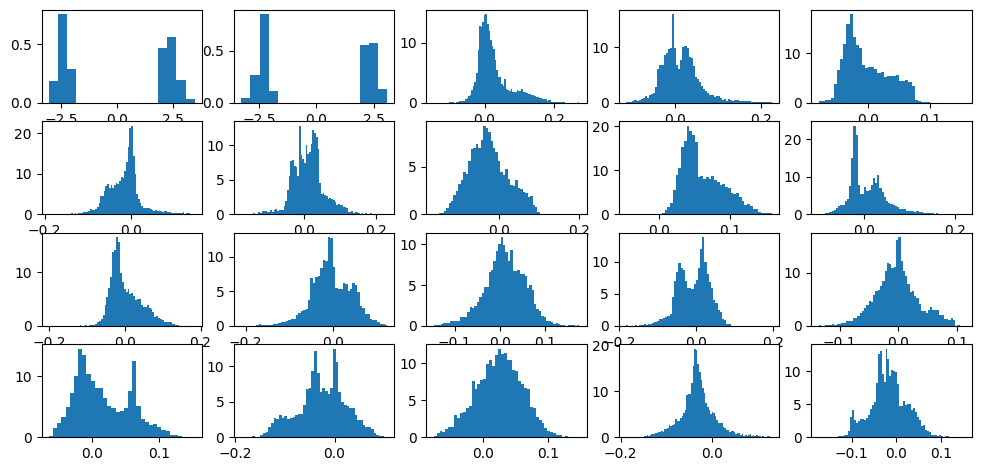

In [23]:
plt.figure(figsize = (12,7))
for i in range(d):
  plt.subplot(5,5,i+1)
  plt.hist(mean_x[:,i], bins = 'auto', density=True);

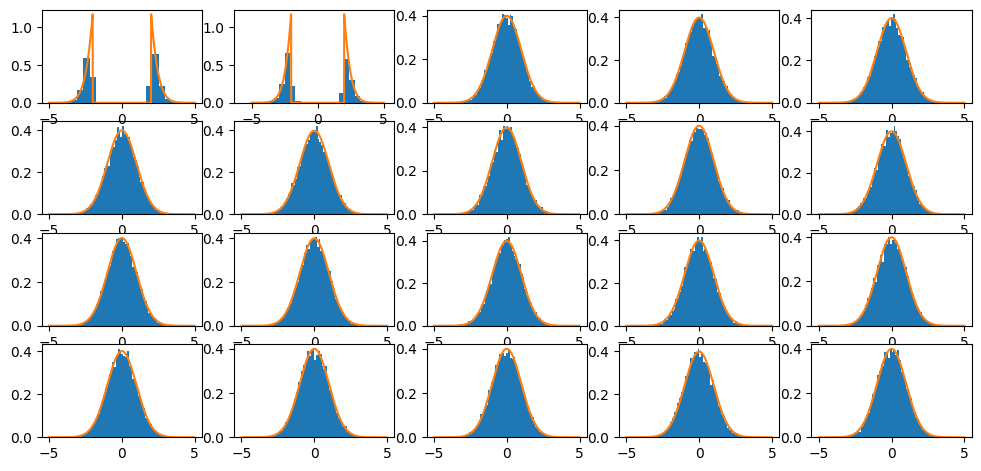

In [23]:
from scipy.stats import norm
xx= np.linspace(-5,5, 1000)
dist1 = ot.TruncatedDistribution(ot.Normal(1), 2., ot.TruncatedDistribution.LOWER)
dist2 = ot.TruncatedDistribution(ot.Normal(1), -2., ot.TruncatedDistribution.UPPER)
dist = ot.Mixture([dist1,dist2])

plt.figure(figsize = (12,7))
for i in range(2,d):
  plt.subplot(5,5,i+1)
  plt.hist(sample[:,i], bins = 'auto', density=True);
  plt.plot(xx, norm.pdf(xx))

plt.subplot(5,5,1)
plt.hist(sample[:,0], bins = 'auto', density=True);
plt.plot(xx, dist.computePDF(xx.reshape(-1,1)))

plt.subplot(5,5,2)
plt.hist(sample[:,1], bins = 'auto', density=True);
plt.plot(xx, dist.computePDF(xx.reshape(-1,1)))


0.0030523263305965317

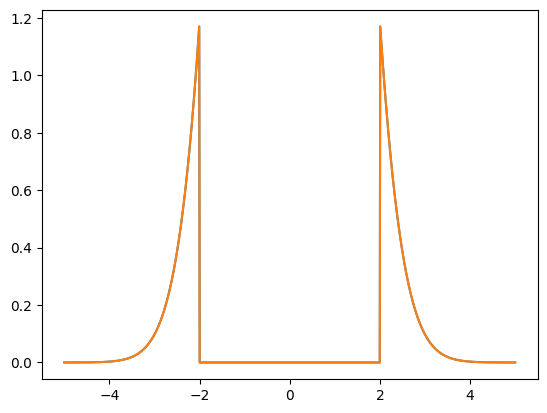

In [85]:
#### Analytic expression vs Openturns ######
x= np.linspace(-5,5,1000).reshape(-1,1)
truncated_dist = (ot.Normal(0,1).computePDF(x) /(1-ot.Normal(0,1).computeCDF(2) +ot.Normal(0,1).computeCDF(-2) )) * ((x>2) + (x<-2))

plt.plot(np.linspace(-5,5,1000), truncated_dist)
plt.plot(np.linspace(-5,5,1000), dist.computePDF(x))
two_side_trunc = ot.Mixture([ot.TruncatedDistribution(ot.Normal(2), 2, ot.TruncatedDistribution.UPPER), 
            ot.TruncatedDistribution(ot.Normal(2), -2, ot.TruncatedDistribution.LOWER)])
ot.Normal(18).computePDF(12)
two_side_trunc.computePDF([2,2])

(1000,)


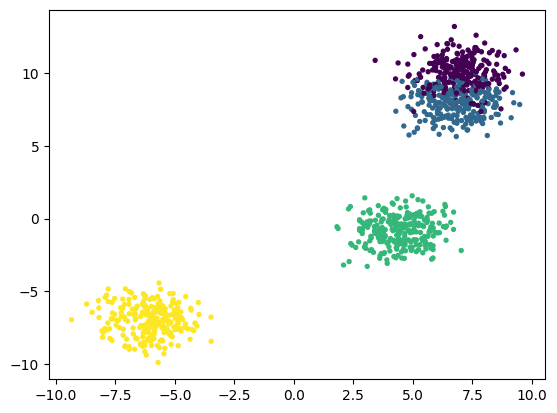

[0.22774348 0.27225652 0.25       0.25      ] 
 [[ 7.00625847 10.06064818]
 [ 6.84011127  8.01934453]
 [ 4.43235281 -0.85459409]
 [-5.99648346 -6.99855134]] 
 [[1.6720895 3.7113385]
 [1.4631212 0.6344708]
 [1.9397347 0.6490665]
 [1.8380207 3.439847 ]]
[[ 7.00684187  9.92368541]
 [ 6.90867802  7.84061357]
 [ 4.41903243 -0.94444451]
 [-5.8980735  -7.06410382]] 



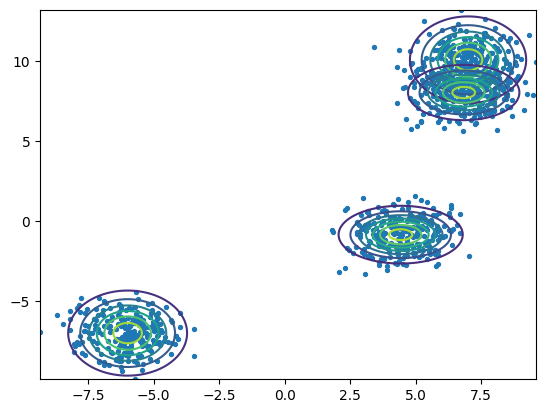

In [15]:
from function.EM import *
#### Testing with make blobs #####

In [39]:
%%time
prior = MoGPrior(2,4)
w_t, mu_t, sigma2_t = EM(z_mean, prior, 2000, 1e-3)
w_t

CPU times: total: 7.67 s
Wall time: 9.35 s


array([0.24962866, 0.25883559, 0.24513383, 0.24640191])

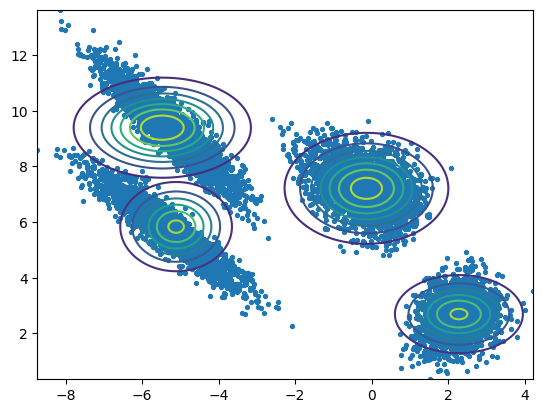

In [40]:
mixture_plot(z_mean.numpy(), w_t, mu_t, sigma2_t, min(z_mean.numpy()[:,0]), max(z_mean.numpy()[:,0]), min(z_mean.numpy()[:,1]), max(z_mean.numpy()[:,1]) )

In [48]:
tf.math.log(tf.constant(3.))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0986123>

In [50]:
w_t.reshape(1,4)

array([[0.24962866, 0.25883559, 0.24513383, 0.24640191]])

In [51]:
mixture.means.assign(tf.constant(mu_t, dtype=tf.float32))
mixture.logvars.assign(tf.math.log(tf.constant(sigma2_t, dtype=tf.float32)))
mixture.w.assign(tf.constant(w_t.reshape(1,-1), dtype=tf.float32))

<tf.Variable 'UnreadVariable' shape=(1, 4) dtype=float32, numpy=array([[0.24962866, 0.25883558, 0.24513383, 0.2464019 ]], dtype=float32)>

In [54]:
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
vae.fit(two_mode, epochs = 150, batch_size = 100, shuffle = True) 

Epoch 1/150
100/100 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - kl_loss: 2.5063 - reconstruction_loss: 14.9031
Epoch 2/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 2.0930 - reconstruction_loss: 9.3280
Epoch 3/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 2.0770 - reconstruction_loss: 8.3989
Epoch 4/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.9868 - reconstruction_loss: 8.1273
Epoch 5/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.9540 - reconstruction_loss: 8.0171
Epoch 6/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.9148 - reconstruction_loss: 7.9300
Epoch 7/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.8668 - reconstruction_loss: 7.8982
Epoch 8/150
100/100 [==============================] - 0s 2ms

In [55]:
z_mean,_, _ = encoder(two_mode)

ColDist = [ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(mixture.means, mixture.logvars)]
weight = np.array(tf.nn.softmax(mixture.w, axis =1)).reshape(-1)
myMixture = ot.Mixture(ColDist, weight)
z =myMixture.getSample(10000)
z= np.array(z)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

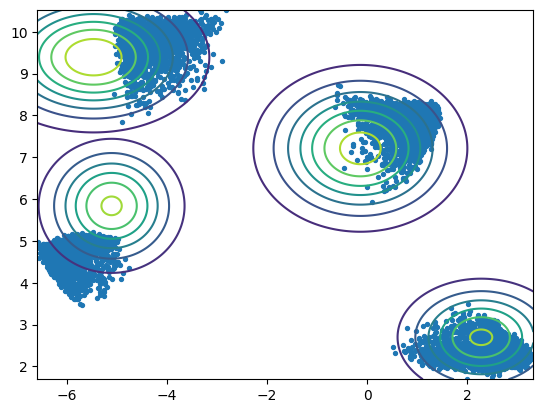

In [60]:
#after VAE training
mixture_plot(z_mean.numpy(), w_t, mu_t, sigma2_t, min(z_mean.numpy()[:,0]), max(z_mean.numpy()[:,0]), min(z_mean.numpy()[:,1]), max(z_mean.numpy()[:,1]) )

In [62]:
mixture.w

<tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[0.24481589, 0.23986244, 0.27842292, 0.23924553]], dtype=float32)>

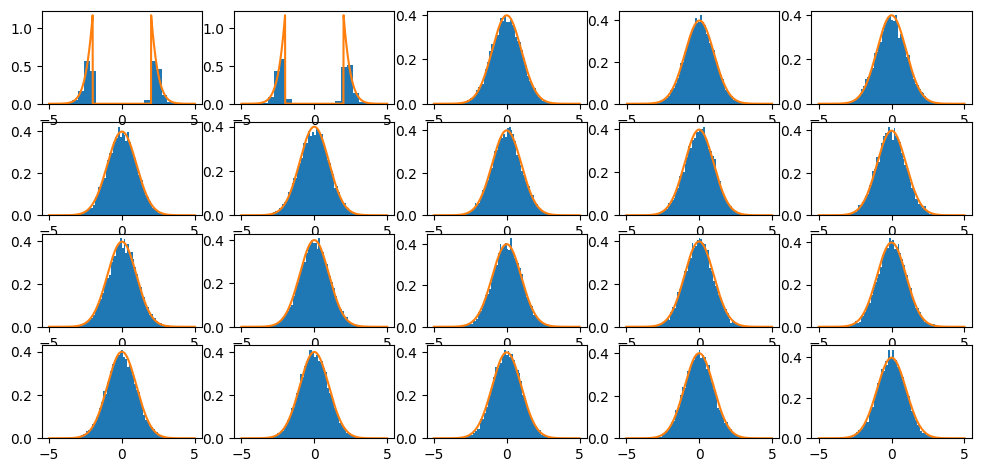

In [56]:
from scipy.stats import norm
xx= np.linspace(-5,5, 1000)
dist1 = ot.TruncatedDistribution(ot.Normal(1), 2., ot.TruncatedDistribution.LOWER)
dist2 = ot.TruncatedDistribution(ot.Normal(1), -2., ot.TruncatedDistribution.UPPER)
dist = ot.Mixture([dist1,dist2])

plt.figure(figsize = (12,7))
for i in range(2,d):
  plt.subplot(5,5,i+1)
  plt.hist(sample[:,i], bins = 'auto', density=True);
  plt.plot(xx, norm.pdf(xx))

plt.subplot(5,5,1)
plt.hist(sample[:,0], bins = 'auto', density=True);
plt.plot(xx, dist.computePDF(xx.reshape(-1,1)))

plt.subplot(5,5,2)
plt.hist(sample[:,1], bins = 'auto', density=True);
plt.plot(xx, dist.computePDF(xx.reshape(-1,1)))

In [64]:
def density_x(vae, n_samples):
    z = vae.prior(n_samples)
    _, _, x_mean, x_log_var = vae.decoder(z) #n_samples distribution 
    Dist = [[ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(x_mean, x_log_var)]]
    Distr_x = ot.Mixture(Dist)
    return Distr_x